# Preguntas teoricas
1. El mejor score para validacion obtenido fue de 0.75
2. El score obtenido para test fue de 0.55
3. Los features mas importantes son attacker_vs_watcher_as_name y attacker_as_name (el grupo 1)

¿cómo conviene elegir los datos de validación respecto de los de train?.
- Conviene separar por ips de atacantes, ya que esta feature presenta una fuerte correlacion con el target, ademas de tenerlas no tendria sentido hacer un modelo de machine learning, tan solo habria que checkear si es o no cierta ip y estaria resuelto el problema. En el caso de dejarlas, el modelo aprendera a discriminar por ips, y cuando haya que predecir para ips fuera de set de train, va a performar muy mal.

# Importante
La metodologia utilizada es la siguiente: se procesa por checkpoints para que no colapse el colab en cuanto a RAM. Cada checkpoint tiene un conjunto de datos asociado (aquel que debe leer), el cual procesara de manera que "entre" en la RAM, por ultimo se persistiran los datos para el siguiente checkpoint.

La idea es que para correr cada checkpoint no haya nada previo, usando los del no se logra al 100% asi que si falla, reiniciar entorno, intentar con el entorno limpio ejecutar el checkpoint

In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from category_encoders import TargetEncoder
from category_encoders import BinaryEncoder
from category_encoders import OneHotEncoder
from category_encoders import HashingEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.linear_model import Perceptron
# from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

# from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import LabelEncoder

import gc

# Checkpoint 1

In [ ]:
train_data = pd.read_parquet('/content/drive/MyDrive/OrgaDeDatos/train.parq')
# test_data = pd.read_parquet('/content/drive/MyDrive/OrgaDeDatos/test.parq')
# # shodan_dataset = pd.read_csv('/content/drive/MyDrive/OrgaDeDatos/shodan_df_hashed.csv')

Atencion, al encodear el attack_time no voy a tener en cuenta el mes, ya que al solo tener 2 valores considero que podria hacer mas ruido que beneficiar al modelo (ademas lo grafique y en el mes 8 hay muchos mas ataques)


**Utilizo la aggregate function max por la siguiente nota de kaggle:**

Note 1: the train and test files contain several rows of signals per IPs, but you should predict only one label per IP in the submission. This also implies that the column "label" in the signals contains always the same value for a given IP


In [ ]:
grouped_ips = train_data.groupby("attacker_ip_enum").agg({'label':'max'}).reset_index()
X = grouped_ips.loc[:, ["attacker_ip_enum"]]
y = grouped_ips.loc[:, ["label"]]
del grouped_ips

In [ ]:
ip_train, ip_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=37, stratify=y)
del X, y, y_train, y_val

## Validation set

In [ ]:
val_data = train_data.loc[train_data["attacker_ip_enum"].isin(set(ip_val.attacker_ip_enum)), :]
del ip_val

In [ ]:
val_data_chunks = np.array_split(val_data, 10)
del val_data

for chunk in val_data_chunks:
    chunk['attack_day'] = chunk.apply(lambda row: row["attack_time"].day, axis=1).astype('int8')
    chunk['attack_hour'] = chunk.apply(lambda row: row["attack_time"].hour, axis=1).astype('int8')
    chunk.drop("attack_time", inplace=True, axis=1)
    del chunk

val_time_encoded = pd.concat(val_data_chunks)
del val_data_chunks

In [ ]:
val_time_encoded.to_parquet('/content/drive/MyDrive/OrgaDeDatos/val_checkpoint1.parq')
del val_time_encoded

## Ahora el set de train

In [ ]:
train_data_splitted = train_data.loc[train_data["attacker_ip_enum"].isin(set(ip_train.attacker_ip_enum)), :]
del train_data, ip_train

In [ ]:
train_data_splitted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52760606 entries, 2 to 61629684
Data columns (total 11 columns):
 #   Column             Dtype              
---  ------             -----              
 0   attack_time        datetime64[ns, UTC]
 1   watcher_country    category           
 2   watcher_as_num     float32            
 3   watcher_as_name    category           
 4   attacker_country   category           
 5   attacker_as_num    float32            
 6   attacker_as_name   category           
 7   attack_type        category           
 8   watcher_uuid_enum  int32              
 9   attacker_ip_enum   int32              
 10  label              int8               
dtypes: category(5), datetime64[ns, UTC](1), float32(2), int32(2), int8(1)
memory usage: 2.1 GB


In [ ]:
train_data_chunks = np.array_split(train_data_splitted, 15)
del train_data_splitted

for chunk in train_data_chunks:
    chunk.drop_duplicates(inplace=True)
    chunk['attack_day'] = chunk.apply(lambda row: row["attack_time"].day, axis=1).astype('int8')
    chunk['attack_hour'] = chunk.apply(lambda row: row["attack_time"].hour, axis=1).astype('int8')
    chunk.drop("attack_time", inplace=True, axis=1)
    del chunk

train_time_encoded = pd.concat(train_data_chunks)
del train_data_chunks

In [ ]:
train_time_encoded.to_parquet("/content/drive/MyDrive/OrgaDeDatos/train_checkpoint1.parq")
del train_time_encoded

## Por ultimo el de test
No se fittea nada, simplemente se le aniade las columnas necesarias para poder usar el modelo

In [ ]:
test_data = pd.read_parquet('/content/drive/MyDrive/OrgaDeDatos/test.parq')
test_data.drop_duplicates(inplace=True)
test_data_chunks = np.array_split(test_data, 10)
del test_data

for chunk in test_data_chunks:
    chunk['attack_day'] = chunk.apply(lambda row: row["attack_time"].day, axis=1).astype('int8')
    chunk['attack_hour'] = chunk.apply(lambda row: row["attack_time"].hour, axis=1).astype('int8')
    chunk.drop("attack_time", inplace=True, axis=1)
    del chunk

test_time_encoded = pd.concat(test_data_chunks)
del test_data_chunks

In [ ]:
test_time_encoded.to_parquet("/content/drive/MyDrive/OrgaDeDatos/test_checkpoint1.parq")
del test_time_encoded

# Checkpoint 2
Se cargan los datos sin duplicados y con attack_type separado en dia y hora.

## Train
**IMPORTANTE**: algunas decisiones tomadas para agrupar son justificadas en base a plots que se pueden encontrar en las visualizaciones (ver colab de visus asociado al tp)

In [ ]:
train_data = pd.read_parquet('/content/drive/MyDrive/OrgaDeDatos/train_checkpoint1.parq')

In [ ]:
train.columns

NameError: ignored

In [ ]:
train_data.drop(["attacker_as_num", "watcher_as_num", "attacker_ip_enum", "watcher_uuid_enum"], inplace=True, axis=1)

In [ ]:
train_data["attack_protocol"] = train_data.attack_type.map(lambda row: row.split(':')[0]).astype("category")
train_data["attack_type"] = train_data.attack_type.map(lambda row: row.split(':')[1]).astype("category")

In [ ]:
mean_attack_hour_by_attacker = train_data.groupby("attacker_as_name").agg({"attack_hour": "sum", "attacker_as_name": "count"})
mean_attack_hour_by_attacker= mean_attack_hour_by_attacker.attack_hour / mean_attack_hour_by_attacker.attacker_as_name
train_data["mean_attack_hour_by_attacker"] = train_data.attacker_as_name.map(mean_attack_hour_by_attacker).astype("float32")
train_data["mean_attack_hour_by_attacker"] = train_data.mean_attack_hour_by_attacker.fillna(0).astype("float32")

Esto es en base a que la mayoria de los ataques con label positivo son previos a las 12 am

In [ ]:
train_data['attacks_before_12_hours'] = train_data[train_data['attack_hour'] < 12].groupby('attacker_as_name')['attack_hour'].transform('count')
train_data['attacks_before_12_hours'] = train_data.attacks_before_12_hours.fillna(0).astype("int32") # Algunos casos tenian categorias sin entries (tiene que ver con cortar validation), al dividir por 0 => NaN

In [ ]:
train_data["attacker_vs_watcher_as_name"] = (train_data.loc[:, "attacker_as_name"].astype("str") + "-" + train_data.loc[:, "watcher_as_name"].astype("str")).astype("category")
train_data["attacker_vs_watcher_country"] = (train_data.loc[:, "attacker_country"].astype("str") + "-" + train_data.loc[:, "watcher_country"].astype("str")).astype("category")

In [ ]:
# train_data["attacker_vs_watcher_as_name"] = train_data.loc[:, ["attacker_vs_watcher_as_name"]].astype("category")
# train_data["attacker_vs_watcher_country"] = train_data.loc[:, ["attacker_vs_watcher_country"]].astype("category")

In [ ]:
attackers_with_most_labels = train_data.groupby("attacker_vs_watcher_as_name").agg({"label": "sum", "attacker_vs_watcher_as_name": "count"})
attackers_with_most_labels.columns = ["label", "attacker_vs_watcher_as_name_count"]
attackers_with_most_labels["relacion"] = (attackers_with_most_labels.label / attackers_with_most_labels.attacker_vs_watcher_as_name_count)
a = attackers_with_most_labels.sort_values(by="relacion", ascending=False)

<Axes: xlabel='attacker_vs_watcher_country'>

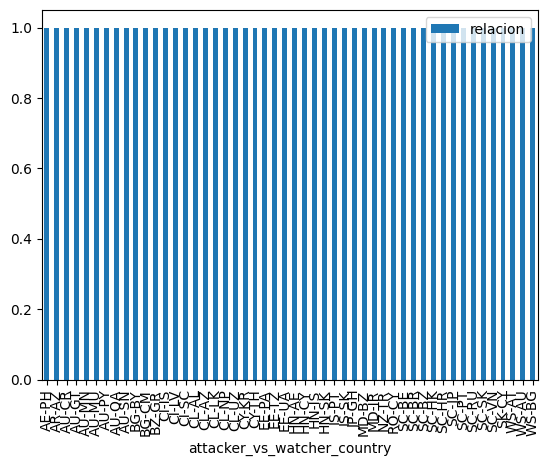

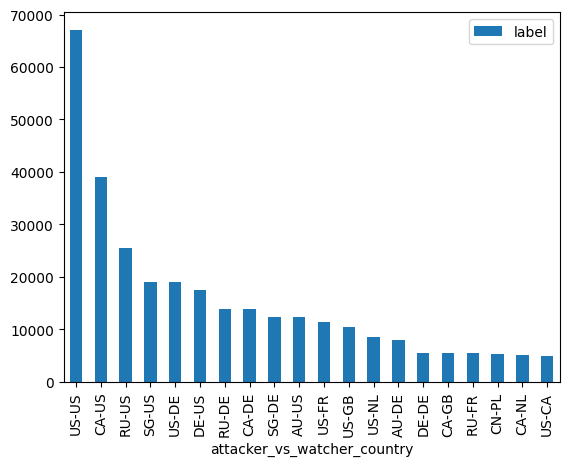

In [ ]:
attackers_with_most_labels = train_data.groupby("attacker_vs_watcher_country").agg({"label": "sum", "attacker_vs_watcher_country": "count"})
attackers_with_most_labels.columns = ["label", "attacker_vs_watcher_as_name_count"]
attackers_with_most_labels["relacion"] = (attackers_with_most_labels.label / attackers_with_most_labels.attacker_vs_watcher_as_name_count)
attackers_with_most_labels.reset_index(inplace=True)
b = attackers_with_most_labels.nlargest(50, columns="relacion")
a=attackers_with_most_labels.nlargest(20, columns='label')
b.plot.bar(x="attacker_vs_watcher_country", y="relacion")
a.plot.bar(x="attacker_vs_watcher_country", y="label")

In [ ]:
def assign_attacker_name_group(row):
  if row == 1.0:
    return "attacker_name_group1"
  elif row >  0.7 and row < 1.0:
    return "attacker_name_group2"
  return "attacker_name_group3"

attacker_name_label_relation = train_data.groupby("attacker_as_name").agg({"label": "sum", "attacker_as_name": "count"})
attacker_name_label_relation.columns = ["label", "attacker_as_name_count"]
attacker_name_label_relation = (attacker_name_label_relation.label / attacker_name_label_relation.attacker_as_name_count)
train_data['attacker_name_label_relation'] = train_data['attacker_as_name'].map(attacker_name_label_relation).astype('float32')
train_data["attacker_as_name"] = train_data.attacker_name_label_relation.map(lambda row: assign_attacker_name_group(row))
train_data["attacker_as_name"] = train_data.loc[:, ["attacker_as_name"]].fillna("attacker_name_group3").astype("category")
train_data.drop("attacker_name_label_relation", axis=1, inplace=True)

In [ ]:
def assign_attacker_vs_watcher_name_group(row):
  if row == 1.0:
    return "attacker_vs_watcher_name_group1"
  elif row >  0.6 and row < 1.0:
    return "attacker_vs_watcher_name_group2"
  return "attacker_vs_watcher_name_group3"

attacker_vs_watcher_name_label_relation = train_data.groupby("attacker_vs_watcher_as_name").agg({"label": "sum", "attacker_vs_watcher_as_name": "count"})
attacker_vs_watcher_name_label_relation.columns = ["label", "attacker_vs_watcher_name_count"]
attacker_vs_watcher_name_label_relation = (attacker_vs_watcher_name_label_relation.label / attacker_vs_watcher_name_label_relation.attacker_vs_watcher_name_count)
train_data['attacker_vs_watcher_name_label_relation'] = train_data['attacker_vs_watcher_as_name'].map(attacker_vs_watcher_name_label_relation).astype('float32')
train_data["attacker_vs_watcher_as_name"] = train_data.attacker_vs_watcher_name_label_relation.map(lambda row: assign_attacker_vs_watcher_name_group(row))
train_data["attacker_vs_watcher_as_name"] = train_data.loc[:, ["attacker_vs_watcher_as_name"]].fillna("attacker_vs_watcher_name_group3").astype("category")
train_data.drop("attacker_vs_watcher_name_label_relation", axis=1, inplace=True)

In [ ]:
def assign_attacker_vs_watcher_country_group(row):
  if row == 1.0:
    return "attacker_vs_watcher_country_group1"
  elif row >  0.6 and row < 1.0:
    return "attacker_vs_watcher_country_group2"
  return "attacker_vs_watcher_country_group3"

attacker_vs_watcher_country_label_relation = train_data.groupby("attacker_vs_watcher_country").agg({"label": "sum", "attacker_vs_watcher_country": "count"})
attacker_vs_watcher_country_label_relation.columns = ["label", "attacker_vs_watcher_country_count"]
attacker_vs_watcher_country_label_relation = (attacker_vs_watcher_country_label_relation.label / attacker_vs_watcher_country_label_relation.attacker_vs_watcher_country_count)
train_data['attacker_vs_watcher_country_label_relation'] = train_data['attacker_vs_watcher_country'].map(attacker_vs_watcher_country_label_relation).astype('float32')
train_data["attacker_vs_watcher_country"] = train_data.attacker_vs_watcher_country_label_relation.map(lambda row: assign_attacker_vs_watcher_country_group(row))
train_data["attacker_vs_watcher_country"] = train_data.loc[:, ["attacker_vs_watcher_country"]].fillna("attacker_vs_watcher_country_group3").astype("category")
train_data.drop("attacker_vs_watcher_country_label_relation", axis=1, inplace=True)

In [ ]:
def assign_watcher_name_group(row):
  if row == 1.0:
    return "watcher_name_group1"
  elif row > 0.4 and row < 1.0:
    return "watcher_name_group2"
  return "watcher_name_group3"

watcher_name_label_relation = train_data.groupby("watcher_as_name").agg({"label": "sum", "watcher_as_name": "count"})
watcher_name_label_relation.columns = ["label", "watcher_as_name_count"]
watcher_name_label_relation = (watcher_name_label_relation.label / watcher_name_label_relation.watcher_as_name_count)
train_data['watcher_name_label_relation'] = train_data.loc[:, 'watcher_as_name'].map(watcher_name_label_relation).astype('float32')
train_data["watcher_as_name"] = train_data.watcher_name_label_relation.map(lambda row: assign_watcher_name_group(row))
train_data["watcher_as_name"] = train_data.loc[:, ["watcher_as_name"]].fillna("watcher_name_group3").astype("category")
train_data.drop("watcher_name_label_relation", axis=1, inplace=True)

In [ ]:
attacker_country_label_relation = train_data.groupby("attacker_country").agg({"label": "sum", "attacker_country": "count"})
attacker_country_label_relation.columns = ["label", "attacker_country_count"]
attacker_country_label_relation = (attacker_country_label_relation.label / attacker_country_label_relation.attacker_country_count).nlargest(2) # Basado en graficos
train_data["attacker_country"] = train_data.loc[:, "attacker_country"].map(lambda row: "attacker_country_group1" if row in attacker_country_label_relation else "attacker_country_group2").astype("category")
train_data["attacker_country" ] = train_data.loc[:, ["attacker_country"]].fillna("attacker_country_group2")

In [ ]:
watcher_country_label_relation = train_data.groupby("watcher_country").agg({"label": "sum", "watcher_country": "count"})
watcher_country_label_relation.columns = ["label", "watcher_country_count"]
watcher_country_label_relation = (watcher_country_label_relation.label / watcher_country_label_relation.watcher_country_count).nlargest(2) # Basado en graficos
train_data["watcher_country"] = train_data.watcher_country.map(lambda row: "watcher_country_group1" if row in watcher_country_label_relation else "watcher_country_group2").astype("category")
train_data["watcher_country" ] = train_data.loc[:, ["watcher_country"]].fillna("watcher_country_group2")

In [ ]:
attack_type_label_relation = train_data.groupby("attack_type").agg({"label": "sum", "attack_type": "count"})
attack_type_label_relation.columns = ["label", "attack_type_count"]
attack_type_label_relation = (attack_type_label_relation.label / attack_type_label_relation.attack_type_count).nlargest(1)
train_data["attack_type"] = train_data.attack_type.map(lambda row: "attack_type_group1" if row in attack_type_label_relation else "attack_type_group2").astype("category")
train_data["attack_type"] = train_data.loc[:, ["attack_type"]].fillna("attack_type_group2").astype("category")

In [ ]:
def assign_attack_protocol_row(row):
  if row > 0.02:
    return "attack_protocol_group1"
  elif row > 0.01 and row < 0.02:
    return "attack_protocol_group2"
  elif row > 0.005 and row < 0.01:
    return "attack_protocol_group3"
  return "attack_protocol_group4"

attack_protocol_label_relation = train_data.groupby("attack_protocol").agg({"label": "sum", "attack_type": "count"})
attack_protocol_label_relation.columns = ["label", "attack_protocol_count"]
attack_protocol_label_relation = (attack_protocol_label_relation.label / attack_protocol_label_relation.attack_protocol_count)
train_data['attack_protocol_label_relation'] = train_data.loc[:, 'attack_protocol'].map(attack_protocol_label_relation).astype('float32')
train_data["attack_protocol"] = train_data.attack_protocol_label_relation.map(lambda row: assign_attack_protocol_row(row))
train_data["attack_protocol"] = train_data.loc[:, ["attack_protocol"]].fillna("attack_protocol_group4").astype("category")
train_data.drop("attack_protocol_label_relation", axis=1, inplace=True)

In [ ]:
X = train_data.drop(["label"], axis=1)
y = train_data.loc[:, "label"]
del train_data

In [ ]:
cols=["watcher_as_name"]
target_encoder = TargetEncoder(cols=cols, smoothing=12)
target_encoder.fit(X.loc[:, cols], y)

TargetEncoder(cols=['watcher_as_name'], smoothing=12)

In [ ]:
X[cols] = target_encoder.transform(X.loc[:, cols])
X[cols] = X.loc[:, cols].astype("float32")

In [ ]:
# sensitivity = 1.0
# laplace_noise = np.random.laplace(loc=0, scale=sensitivity, size=len(X))
# for col in cols:
#   X[col] += laplace_noise

In [ ]:
first_ohe_cols=['attack_type'] #attacker_country
ohe_encoder = OneHotEncoder(cols=first_ohe_cols)
ohe_encoder.fit(X.loc[:, first_ohe_cols])

OneHotEncoder(cols=['attack_type'])

In [ ]:
first_ohe_result = ohe_encoder.transform(X.loc[:, first_ohe_cols]).astype("int8")
X.drop(first_ohe_cols, axis=1, inplace=True)
X = pd.concat([X, first_ohe_result], axis=1)
del first_ohe_result

In [ ]:
second_ohe_cols = ["attacker_country"]
second_ohe_encoder = OneHotEncoder(cols=second_ohe_cols)
second_ohe_encoder.fit(X.loc[:, second_ohe_cols])

OneHotEncoder(cols=['attacker_country'])

In [ ]:
second_ohe_result = second_ohe_encoder.transform(X.loc[:, second_ohe_cols]).astype("int8")
X.drop(second_ohe_cols, axis=1, inplace=True)
X = pd.concat([X, second_ohe_result], axis=1)
del second_ohe_result

In [ ]:
third_ohe_cols = ["watcher_country"]
third_ohe_encoder = OneHotEncoder(cols=third_ohe_cols)
third_ohe_encoder.fit(X.loc[:, third_ohe_cols])

OneHotEncoder(cols=['watcher_country'])

In [ ]:
third_ohe_result = third_ohe_encoder.transform(X.loc[:, third_ohe_cols]).astype("int8")
X.drop(third_ohe_cols, axis=1, inplace=True)
X = pd.concat([X, third_ohe_result], axis=1)
del third_ohe_result

In [ ]:
fourth_ohe_cols = ["attacker_as_name"]
fourth_ohe_encoder = OneHotEncoder(cols=fourth_ohe_cols)
fourth_ohe_encoder.fit(X.loc[:, fourth_ohe_cols])
# binary_encoder = BinaryEncoder(cols=binary_cols)
# binary_encoder.fit(X.loc[:, binary_cols])

OneHotEncoder(cols=['attacker_as_name'])

In [ ]:
fourth_ohe_result = fourth_ohe_encoder.transform(X.loc[:, fourth_ohe_cols]).astype("int8")
X.drop(fourth_ohe_cols, axis=1, inplace=True)
X = pd.concat([X, fourth_ohe_result], axis=1)
del fourth_ohe_result

In [ ]:
fifth_ohe_cols = ["attack_protocol"]
fifth_ohe_encoder = OneHotEncoder(cols=fifth_ohe_cols)
fifth_ohe_encoder.fit(X.loc[:, fifth_ohe_cols])

OneHotEncoder(cols=['attack_protocol'])

In [ ]:
fifth_ohe_result = fifth_ohe_encoder.transform(X.loc[:, fifth_ohe_cols]).astype("int8")
X.drop(fifth_ohe_cols, axis=1, inplace=True)
X = pd.concat([X, fifth_ohe_result], axis=1)
del fifth_ohe_result

In [ ]:
sixth_ohe_cols = ["attacker_vs_watcher_as_name"]
sixth_ohe_encoder = OneHotEncoder(cols=sixth_ohe_cols)
sixth_ohe_encoder.fit(X.loc[:, sixth_ohe_cols])

OneHotEncoder(cols=['attacker_vs_watcher_as_name'])

In [ ]:
sixth_ohe_result = sixth_ohe_encoder.transform(X.loc[:, sixth_ohe_cols]).astype("int8")
X.drop(sixth_ohe_cols, axis=1, inplace=True)
X = pd.concat([X, sixth_ohe_result], axis=1)
del sixth_ohe_result

In [ ]:
seventh_ohe_cols = ["attacker_vs_watcher_country"]
seventh_ohe_encoder = OneHotEncoder(cols=seventh_ohe_cols)
seventh_ohe_encoder.fit(X.loc[:, seventh_ohe_cols])

OneHotEncoder(cols=['attacker_vs_watcher_country'])

In [ ]:
seventh_ohe_result = seventh_ohe_encoder.transform(X.loc[:, seventh_ohe_cols]).astype("int8")
X.drop(seventh_ohe_cols, axis=1, inplace=True)
X = pd.concat([X, seventh_ohe_result], axis=1)
del seventh_ohe_result

In [ ]:
train_data = pd.concat([X, y], axis=1)
del X, y

In [ ]:
train_data.to_parquet('/content/drive/MyDrive/OrgaDeDatos/train_checkpoint2.parq')
del train_data

## Validation

In [ ]:
val_data = pd.read_parquet('/content/drive/MyDrive/OrgaDeDatos/val_checkpoint1.parq')

In [ ]:
val_data.drop(["watcher_as_num", "attacker_as_num", "attacker_ip_enum", "watcher_uuid_enum"], inplace=True, axis=1)

In [ ]:
val_data["attack_protocol"] = val_data.attack_type.map(lambda row: row.split(':')[0]).astype("category")
val_data["attack_type"] = val_data.attack_type.map(lambda row: row.split(':')[1]).astype("category")

mean_attack_hour_by_attacker = val_data.groupby("attacker_as_name").agg({"attack_hour": "sum", "attacker_as_name": "count"})
mean_attack_hour_by_attacker= mean_attack_hour_by_attacker.attack_hour / mean_attack_hour_by_attacker.attacker_as_name
val_data["mean_attack_hour_by_attacker"] = val_data.attacker_as_name.map(mean_attack_hour_by_attacker)
val_data["mean_attack_hour_by_attacker"] = val_data.mean_attack_hour_by_attacker.fillna(0).astype("float32")


val_data['attacks_before_12_hours'] = val_data[val_data['attack_hour'] < 12].groupby('attacker_as_name')['attack_hour'].transform('count')
val_data['attacks_before_12_hours'] = val_data.attacks_before_12_hours.fillna(0).astype("int32")

In [ ]:
val_data["attacker_vs_watcher_as_name"] = val_data.loc[:, "attacker_as_name"].astype("str") + "-" + val_data.loc[:, "watcher_as_name"].astype("str")
val_data["attacker_vs_watcher_country"] = val_data.loc[:, "attacker_country"].astype("str") + "-" + val_data.loc[:, "watcher_country"].astype("str")
val_data["attacker_vs_watcher_as_name"] = val_data.loc[:, ["attacker_vs_watcher_as_name"]].astype("category")
val_data["attacker_vs_watcher_country"] = val_data.loc[:, ["attacker_vs_watcher_country"]].astype("category")

In [ ]:
val_data['attacker_name_label_relation'] = val_data['attacker_as_name'].map(attacker_name_label_relation).astype('float32')
val_data["attacker_as_name"] = val_data.attacker_name_label_relation.map(lambda row: assign_attacker_name_group(row))
val_data["attacker_as_name"] = val_data.loc[:, ["attacker_as_name"]].fillna("attacker_name_group3").astype("category")
val_data.drop("attacker_name_label_relation", axis=1, inplace=True)

In [ ]:
val_data['watcher_name_label_relation'] = val_data.loc[:, 'watcher_as_name'].map(watcher_name_label_relation).astype('float32')
val_data["watcher_as_name"] = val_data.watcher_name_label_relation.map(lambda row: assign_watcher_name_group(row))
val_data["watcher_as_name"] = val_data.loc[:, ["watcher_as_name"]].fillna("watcher_name_group3").astype("category")
val_data.drop("watcher_name_label_relation", axis=1, inplace=True)

In [ ]:
val_data["attacker_country"] = val_data.loc[:, "attacker_country"].map(lambda row: "attacker_country_group1" if row in attacker_country_label_relation else "attacker_country_group2").astype("category")
val_data["attacker_country" ] = val_data.loc[:, ["attacker_country"]].fillna("attacker_country_group2")

In [ ]:
val_data["watcher_country"] = val_data.watcher_country.map(lambda row: "watcher_country_group1" if row in watcher_country_label_relation else "watcher_country_group2").astype("category")
val_data["watcher_country" ] = val_data.loc[:, ["watcher_country"]].fillna("watcher_country_group2")

In [ ]:
val_data["attack_type"] = val_data.attack_type.map(lambda row: "attack_type_group1" if row in attack_type_label_relation else "attack_type_group2").astype("category")
val_data["attack_type"] = val_data.loc[:, ["attack_type"]].fillna("attack_type_group2").astype("category")

In [ ]:
val_data['attack_protocol_label_relation'] = val_data.loc[:, 'attack_protocol'].map(attack_protocol_label_relation).astype('float32')
val_data["attack_protocol"] = val_data.attack_protocol_label_relation.map(lambda row: assign_attack_protocol_row(row))
val_data["attack_protocol"] = val_data.loc[:, ["attack_protocol"]].fillna("attack_protocol_group4").astype("category")
val_data.drop("attack_protocol_label_relation", axis=1, inplace=True)

In [ ]:
val_data['attacker_vs_watcher_name_label_relation'] = val_data['attacker_vs_watcher_as_name'].map(attacker_vs_watcher_name_label_relation).astype('float32')
val_data["attacker_vs_watcher_as_name"] = val_data.attacker_vs_watcher_name_label_relation.map(lambda row: assign_attacker_vs_watcher_name_group(row))
val_data["attacker_vs_watcher_as_name"] = val_data.loc[:, ["attacker_vs_watcher_as_name"]].fillna("attacker_vs_watcher_name_group3").astype("category")
val_data.drop("attacker_vs_watcher_name_label_relation", axis=1, inplace=True)

In [ ]:
val_data['attacker_vs_watcher_country_label_relation'] = val_data['attacker_vs_watcher_country'].map(attacker_vs_watcher_country_label_relation).astype('float32')
val_data["attacker_vs_watcher_country"] = val_data.attacker_vs_watcher_country_label_relation.map(lambda row: assign_attacker_vs_watcher_country_group(row))
val_data["attacker_vs_watcher_country"] = val_data.loc[:, ["attacker_vs_watcher_country"]].fillna("attacker_vs_watcher_country_group3").astype("category")
val_data.drop("attacker_vs_watcher_country_label_relation", axis=1, inplace=True)

In [ ]:
X = val_data.drop("label", axis=1)
y = val_data.loc[:, ["label"]]
del val_data

In [ ]:
first_ohe_result = ohe_encoder.transform(X.loc[:, first_ohe_cols])
X.drop(first_ohe_cols, axis=1, inplace=True)
X = pd.concat([X, first_ohe_result], axis=1)
del first_ohe_result
second_ohe_result = second_ohe_encoder.transform(X.loc[:, second_ohe_cols]).astype("int8")
X.drop(second_ohe_cols, axis=1, inplace=True)
X = pd.concat([X, second_ohe_result], axis=1)
del second_ohe_result
third_ohe_result = third_ohe_encoder.transform(X.loc[:, third_ohe_cols]).astype("int8")
X.drop(third_ohe_cols, axis=1, inplace=True)
X = pd.concat([X, third_ohe_result], axis=1)
del third_ohe_result
# binary_result = binary_encoder.transform(X.loc[:, binary_cols]).astype("int8")
# X.drop(binary_cols, axis=1, inplace=True)
# X = pd.concat([X, binary_result], axis=1)
# del binary_result
fourth_ohe_result = fourth_ohe_encoder.transform(X.loc[:, fourth_ohe_cols]).astype("int8")
X.drop(fourth_ohe_cols, axis=1, inplace=True)
X = pd.concat([X, fourth_ohe_result], axis=1)
del fourth_ohe_result
fifth_ohe_result = fifth_ohe_encoder.transform(X.loc[:, fifth_ohe_cols]).astype("int8")
X.drop(fifth_ohe_cols, axis=1, inplace=True)
X = pd.concat([X, fifth_ohe_result], axis=1)
del fifth_ohe_result
sixth_ohe_result = sixth_ohe_encoder.transform(X.loc[:, sixth_ohe_cols]).astype("int8")
X.drop(sixth_ohe_cols, axis=1, inplace=True)
X = pd.concat([X, sixth_ohe_result], axis=1)
del sixth_ohe_result
seventh_ohe_result = seventh_ohe_encoder.transform(X.loc[:, seventh_ohe_cols]).astype("int8")
X.drop(seventh_ohe_cols, axis=1, inplace=True)
X = pd.concat([X, seventh_ohe_result], axis=1)
del seventh_ohe_result

In [ ]:
X[cols] = target_encoder.transform(X.loc[:, cols])
val_encoded = pd.concat([X, y], axis=1)
del X, y

In [ ]:
# sensitivity = 1.0
# laplace_noise = np.random.laplace(loc=0, scale=sensitivity, size=len(val_encoded))
# for col in cols:
#   val_encoded[col] += laplace_noise

In [ ]:
val_encoded.to_parquet('/content/drive/MyDrive/OrgaDeDatos/val_checkpoint2.parq')
del val_encoded

## Test

In [ ]:
test_data = pd.read_parquet('/content/drive/MyDrive/OrgaDeDatos/test_checkpoint1.parq')

In [ ]:
test_data.drop(["watcher_as_num", "attacker_as_num", "attacker_ip_enum", "watcher_uuid_enum"], inplace=True, axis=1)

In [ ]:
test_data["attack_protocol"] = test_data.attack_type.map(lambda row: row.split(':')[0]).astype("category")
test_data["attack_type"] = test_data.attack_type.map(lambda row: row.split(':')[1]).astype("category")

mean_attack_hour_by_attacker = test_data.groupby("attacker_as_name").agg({"attack_hour": "sum", "attacker_as_name": "count"})
mean_attack_hour_by_attacker= mean_attack_hour_by_attacker.attack_hour / mean_attack_hour_by_attacker.attacker_as_name
test_data["mean_attack_hour_by_attacker"] = test_data.attacker_as_name.map(mean_attack_hour_by_attacker).astype("float32")
test_data["mean_attack_hour_by_attacker"] = test_data.mean_attack_hour_by_attacker.fillna(0).astype("float32")

test_data['attacks_before_12_hours'] = test_data[test_data['attack_hour'] < 12].groupby('attacker_as_name')['attack_hour'].transform('count')
test_data['attacks_before_12_hours'] = test_data.attacks_before_12_hours.fillna(0).astype("int32")

In [ ]:
test_data["attacker_vs_watcher_as_name"] = test_data.loc[:, "attacker_as_name"].astype("str") + "-" + test_data.loc[:, "watcher_as_name"].astype("str")
test_data["attacker_vs_watcher_country"] = test_data.loc[:, "attacker_country"].astype("str") + "-" + test_data.loc[:, "watcher_country"].astype("str")
test_data["attacker_vs_watcher_as_name"] = test_data.loc[:, ["attacker_vs_watcher_as_name"]].astype("category")
test_data["attacker_vs_watcher_country"] = test_data.loc[:, ["attacker_vs_watcher_country"]].astype("category")

In [ ]:
test_data['attacker_name_label_relation'] = test_data['attacker_as_name'].map(attacker_name_label_relation).astype('float32')
test_data["attacker_as_name"] = test_data.attacker_name_label_relation.map(lambda row: assign_attacker_name_group(row))
test_data["attacker_as_name"] = test_data.loc[:, ["attacker_as_name"]].fillna("attacker_name_group3").astype("category")
test_data.drop("attacker_name_label_relation", axis=1, inplace=True)

In [ ]:
test_data['watcher_name_label_relation'] = test_data.loc[:, 'watcher_as_name'].map(watcher_name_label_relation).astype('float32')
test_data["watcher_as_name"] = test_data.watcher_name_label_relation.map(lambda row: assign_watcher_name_group(row))
test_data["watcher_as_name"] = test_data.loc[:, ["watcher_as_name"]].fillna("watcher_name_group3").astype("category")
test_data.drop("watcher_name_label_relation", axis=1, inplace=True)

In [ ]:
test_data["attacker_country"] = test_data.loc[:, "attacker_country"].map(lambda row: "attacker_country_group1" if row in attacker_country_label_relation else "attacker_country_group2").astype("category")
test_data["attacker_country" ] = test_data.loc[:, ["attacker_country"]].fillna("attacker_country_group2")

In [ ]:
test_data["watcher_country"] = test_data.watcher_country.map(lambda row: "watcher_country_group1" if row in watcher_country_label_relation else "watcher_country_group2").astype("category")
test_data["watcher_country" ] = test_data.loc[:, ["watcher_country"]].fillna("watcher_country_group2")

In [ ]:
test_data["attack_type"] = test_data.attack_type.map(lambda row: "attack_type_group1" if row in attack_type_label_relation else "attack_type_group2").astype("category")
test_data["attack_type"] = test_data.loc[:, ["attack_type"]].fillna("attack_type_group2").astype("category")

In [ ]:
test_data['attack_protocol_label_relation'] = test_data.loc[:, 'attack_protocol'].map(attack_protocol_label_relation).astype('float32')
test_data["attack_protocol"] = test_data.attack_protocol_label_relation.map(lambda row: assign_attack_protocol_row(row))
test_data["attack_protocol"] = test_data.loc[:, ["attack_protocol"]].fillna("attack_protocol_group4").astype("category")
test_data.drop("attack_protocol_label_relation", axis=1, inplace=True)

In [ ]:
test_data['attacker_vs_watcher_name_label_relation'] = test_data['attacker_vs_watcher_as_name'].map(attacker_vs_watcher_name_label_relation).astype('float32')
test_data["attacker_vs_watcher_as_name"] = test_data.attacker_vs_watcher_name_label_relation.map(lambda row: assign_attacker_vs_watcher_name_group(row))
test_data["attacker_vs_watcher_as_name"] = test_data.loc[:, ["attacker_vs_watcher_as_name"]].fillna("attacker_vs_watcher_name_group3").astype("category")
test_data.drop("attacker_vs_watcher_name_label_relation", axis=1, inplace=True)

In [ ]:
test_data['attacker_vs_watcher_country_label_relation'] = test_data['attacker_vs_watcher_country'].map(attacker_vs_watcher_country_label_relation).astype('float32')
test_data["attacker_vs_watcher_country"] = test_data.attacker_vs_watcher_country_label_relation.map(lambda row: assign_attacker_vs_watcher_country_group(row))
test_data["attacker_vs_watcher_country"] = test_data.loc[:, ["attacker_vs_watcher_country"]].fillna("attacker_vs_watcher_country_group3").astype("category")
test_data.drop("attacker_vs_watcher_country_label_relation", axis=1, inplace=True)

In [ ]:
# test_data['attack_type_label_relation'] = test_data.loc[:, 'attack_type'].map(attack_type_label_relation).astype('float32')
# test_data["attack_type"] = test_data.attack_type_label_relation.map(lambda row: assign_attack_type_group(row))
# test_data["attack_type"] = test_data.loc[:, ["attack_type"]].fillna("attack_type_group3").astype("category")
# test_data.drop("attack_type_label_relation", axis=1, inplace=True)

In [ ]:
# test_data["attacker_as_name"] = test_data.attacker_as_name.map(lambda row: row if row in attackers_with_most_labels else "other_attacker_name")
# test_data["attacker_as_name" ] = test_data.loc[:, ["attacker_as_name"]].fillna("other_attacker_name")
# test_data["watcher_as_name"] = test_data.watcher_as_name.map(lambda row: row if row in watchers_with_most_labels else "other_watcher_name")
# test_data["watcher_as_name"] = test_data.loc[:, ["watcher_as_name"]].fillna("other_watcher_name")
# test_data["attacker_country"] = test_data.attacker_country.map(lambda row: row if row in attacker_countries_with_most_labels else "other_attacker_country")
# test_data["attacker_country" ] = test_data.loc[:, ["attacker_country"]].fillna("other_attacker_country")
# test_data["watcher_country"] = test_data.watcher_country.map(lambda row: row if row in watcher_countries_with_most_labels else "other_watcher_country")
# test_data["watcher_country" ] = test_data.loc[:, ["watcher_country"]].fillna("other_watcher_country")
# test_data["attack_type"] = test_data.attack_type.map(lambda row: "http" if "http" in row else "other_attack_type")
# test_data["attack_type"] = test_data.loc[:, ["attack_type"]].fillna("other_attack_type")

In [ ]:
first_ohe_result = ohe_encoder.transform(test_data.loc[:, first_ohe_cols])
test_data.drop(first_ohe_cols, axis=1, inplace=True)
test_data = pd.concat([test_data, first_ohe_result], axis=1)
del first_ohe_result
second_ohe_result = second_ohe_encoder.transform(test_data.loc[:, second_ohe_cols]).astype("int8")
test_data.drop(second_ohe_cols, axis=1, inplace=True)
test_data = pd.concat([test_data, second_ohe_result], axis=1)
del second_ohe_result
third_ohe_result = third_ohe_encoder.transform(test_data.loc[:, third_ohe_cols]).astype("int8")
test_data.drop(third_ohe_cols, axis=1, inplace=True)
test_data = pd.concat([test_data, third_ohe_result], axis=1)
del third_ohe_result
# binary_result = binary_encoder.transform(test_data.loc[:, binary_cols]).astype("int8")
# test_data.drop(binary_cols, axis=1, inplace=True)
# test_data = pd.concat([test_data, binary_result], axis=1)
# del binary_result
fourth_ohe_result = fourth_ohe_encoder.transform(test_data.loc[:, fourth_ohe_cols]).astype("int8")
test_data.drop(fourth_ohe_cols, axis=1, inplace=True)
test_data = pd.concat([test_data, fourth_ohe_result], axis=1)
del fourth_ohe_result
fifth_ohe_result = fifth_ohe_encoder.transform(test_data.loc[:, fifth_ohe_cols]).astype("int8")
test_data.drop(fifth_ohe_cols, axis=1, inplace=True)
test_data = pd.concat([test_data, fifth_ohe_result], axis=1)
del fifth_ohe_result
sixth_ohe_result = sixth_ohe_encoder.transform(test_data.loc[:, sixth_ohe_cols]).astype("int8")
test_data.drop(sixth_ohe_cols, axis=1, inplace=True)
test_data = pd.concat([test_data, sixth_ohe_result], axis=1)
del sixth_ohe_result
seventh_ohe_result = seventh_ohe_encoder.transform(test_data.loc[:, seventh_ohe_cols]).astype("int8")
test_data.drop(seventh_ohe_cols, axis=1, inplace=True)
test_data = pd.concat([test_data, seventh_ohe_result], axis=1)
del seventh_ohe_result

In [ ]:
test_data[cols] = target_encoder.transform(test_data.loc[:, cols])

In [ ]:
# sensitivity = 1.0
# laplace_noise = np.random.laplace(loc=0, scale=sensitivity, size=len(test_data))
# for col in cols:
#   test_data[col] += laplace_noise

In [ ]:
test_data.head()

,watcher_as_name,attack_day,attack_hour,mean_attack_hour_by_attacker,attacks_before_12_hours,attack_type_1,attack_type_2,attacker_country_1,attacker_country_2,watcher_country_1,...,attack_protocol_1,attack_protocol_2,attack_protocol_3,attack_protocol_4,attacker_vs_watcher_as_name_1,attacker_vs_watcher_as_name_2,attacker_vs_watcher_as_name_3,attacker_vs_watcher_country_1,attacker_vs_watcher_country_2,attacker_vs_watcher_country_3
0,0.017736,31,7,10.992494,659497,1,0,1,0,1,...,1,0,0,0,1,0,0,1,0,0
1,0.017736,31,7,10.992494,659497,1,0,1,0,1,...,1,0,0,0,1,0,0,1,0,0
2,0.017736,31,7,10.992494,659497,1,0,1,0,1,...,1,0,0,0,1,0,0,1,0,0
4,0.017736,31,7,11.139756,27661,1,0,1,0,1,...,1,0,0,0,1,0,0,1,0,0
5,0.017736,31,7,11.139756,27661,1,0,1,0,1,...,1,0,0,0,1,0,0,1,0,0


In [ ]:
test_data.to_parquet("/content/drive/MyDrive/OrgaDeDatos/test_checkpoint2.parq")
del test_data, ohe_encoder, second_ohe_encoder, target_encoder, third_ohe_encoder, fourth_ohe_encoder

# Perceptron

## Aclaracion:
Antes de usar las columnas mean_attack_hour_by_attacker y attacks_before_12_hours, el score de validacion obtenido fue de 0.75, y en la competencia ~0.53

In [ ]:
train_data = pd.read_parquet('/content/drive/MyDrive/OrgaDeDatos/train_checkpoint2.parq')

In [ ]:
not_label_df = train_data.loc[train_data["label"]==0, :]
label_df = train_data.loc[train_data["label"]==1, :]

In [ ]:
not_label_ammount = round(len(label_df) * 100 / 30) # Regla de 3 simple

In [ ]:
# not_label_df = not_label_df.iloc[: not_label_ammount - len(label_df), :]
random_not_label_df = not_label_df.sample(n=not_label_ammount - len(label_df), random_state=37)


In [ ]:
del train_data
train_data = pd.concat([label_df, random_not_label_df], axis=0)
del not_label_df, label_df

In [ ]:
X_train = train_data.drop("label", axis=1)
y_train = train_data.loc[:, "label"]
del train_data

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

perceptron = Perceptron()
param_grid = {
    'alpha': [1e-3, 1e-7, 1e-9],
    'penalty': ['l1', 'l2'],
    'max_iter': [10, 30, 60],
    'eta0': [1, 1.2, 1.4],
    'random_state': [37, 73, 24],

}
f1_scorer = make_scorer(f1_score)
# # random_search = RandomizedSearchCV(
#     # perceptron, param_distributions=param_grid, cv=3, n_iter=3, n_jobs=-1, random_state=73, verbose=2, scoring=f1_scorer)
# # random_search.fit(X_test_sample, y_test_sample)
grid_search = GridSearchCV(estimator=perceptron, param_grid=param_grid, scoring=f1_scorer, cv=3)  # cv es la validación cruzada
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic

GridSearchCV(cv=3, estimator=Perceptron(),
             param_grid={'alpha': [0.001, 1e-07, 1e-09], 'eta0': [1, 1.2, 1.4],
                         'max_iter': [10, 30, 60], 'penalty': ['l1', 'l2'],
                         'random_state': [37, 73, 24]},
             scoring=make_scorer(f1_score))

In [ ]:
params ={'alpha': 0.001,
 'eta0': 1.2,
 'max_iter': 10,
 'penalty': 'l1',
 'random_state': 24}
  # ESTOS PARAMETROS FUERON OBTENIDOS MEDIANTE GRIDSEARCH SIN UTILIZAR LAS COLUMNAS QUE DROPPEO MAS ADELANTE
perceptron = Perceptron(**params)

In [ ]:
perceptron.fit(X_train.drop(["attacks_before_12_hours", "mean_attack_hour_by_attacker"], axis=1), y_train)

Perceptron(alpha=0.001, eta0=1.2, max_iter=10, penalty='l1', random_state=24)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.barplot(x=X_train.columns, y=grid_search.best_estimator_.coef_[0], color="#16e016")
plt.xlabel('Feature')
plt.ylabel('Importancia')
plt.title("Feature Importance")
plt.xticks(rotation=90)
ax.set_yscale("symlog")  # Configura el eje Y en escala logarítmica
plt.show()


In [ ]:
val_data = pd.read_parquet('/content/drive/MyDrive/OrgaDeDatos/val_checkpoint2.parq')

In [ ]:
X_val = val_data.drop("label", axis=1)
y_val = val_data.loc[:, ["label"]]
del val_data

In [ ]:
a = val_data.groupby("attacker_ip_enum").agg({"label":"sum", "attacker_ip_enum": "count"})

In [ ]:
b = a.label / a.attacker_ip_enum

NameError: ignored

In [ ]:
m = b.mean()
c = b.apply(lambda x: 1 if x > m else 0)

NameError: ignored

In [ ]:
val_pred = perceptron.predict(X_val.drop(["attacks_before_12_hours", "mean_attack_hour_by_attacker"], axis=1))
train_pred = perceptron.predict(X_train.drop(["attacks_before_12_hours", "mean_attack_hour_by_attacker"], axis=1))

In [ ]:
val_pred = grid_search.predict(X_val)
train_pred = grid_search.predict(X_train)

NameError: ignored

In [ ]:
print(f"train score: {f1_score(y_train, train_pred)}")
print(f"val score: {f1_score(y_val, val_pred)}")


train score: 0.6562973116934937
val score: 0.26411351915359227


# Test y submission

In [ ]:
test_data = pd.read_parquet('/content/drive/MyDrive/OrgaDeDatos/test_checkpoint2.parq')

In [ ]:
test_pred = grid_search.predict(test_data)

In [ ]:
test_data = pd.read_parquet('/content/drive/MyDrive/OrgaDeDatos/test_checkpoint1.parq')

In [ ]:
test_data["label"] = test_pred

In [ ]:
# a = test_data.groupby("attacker_ip_enum").agg({"label": "max"})

In [ ]:
a = test_data.groupby("attacker_ip_enum").agg({"label":"sum", "attacker_ip_enum": "count"})

In [ ]:
b = a.label / a.attacker_ip_enum

In [ ]:
m = b.mean()
c = b.apply(lambda x: 1 if x > m else 0)

In [ ]:
d = c.reset_index()
d.columns = ["attacker_ip_enum", "label"]
d["attacker_ip_enum"] = d.loc[:, "attacker_ip_enum"].astype("int32")
d["label"] = d.loc[:, "label"].astype("int8")

In [ ]:
# d = d.reset_index()
# d.columns = ["attacker_ip_enum", "label"]
# d["attacker_ip_enum"] = d.loc[:, "attacker_ip_enum"].astype("int32")
# d["label"] = d.loc[:, "label"].astype("int8")

In [ ]:
d.to_csv("/content/drive/MyDrive/OrgaDeDatos/perceptron_preds3.csv", index=False)